In the first part of the book, the author spends a lot of pages to explain how to prepare features and labels for training ML models. One of the part is about labeling. We briefly go through how to label data with my implementation.

In [1]:
import pandas as pd

df = pd.read_csv('data/MSFT.csv', index_col=0)
start = '2000-01-01'
end = '2018-01-01'
df.index = pd.DatetimeIndex(df.index)
df = df.loc[(df.index >= start) & (df.index <= end)]

In [2]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


We use `Close` for labeling.

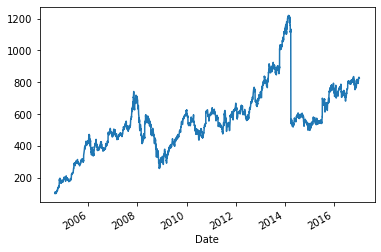

In [3]:
%matplotlib inline
close = df['Close']
close.plot();

By reducing data points, we are able to train more efficiently and effectively. One of the examples is CUSUM Filter. CUSUM Filter samples points when data points deviate from historical means.

DatetimeIndex(['2004-08-26', '2004-08-27', '2004-08-30', '2004-09-01',
               '2004-09-02', '2004-09-03', '2004-09-07', '2004-09-10',
               '2004-09-13', '2004-09-16',
               ...
               '2016-12-07', '2016-12-09', '2016-12-16', '2016-12-22',
               '2016-12-30', '2017-01-03', '2017-01-05', '2017-01-06',
               '2017-01-11', '2017-01-17'],
              dtype='datetime64[ns]', length=1600, freq=None)


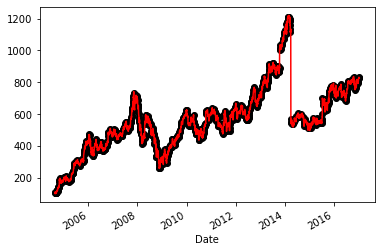

In [4]:
from finance_ml.stats import get_vol
from finance_ml.labeling import cusum_filter
import matplotlib.pyplot as plt

h = 2 * close * get_vol(close,span=100,days=1)
timestamps = cusum_filter(close, h)
print(timestamps)

start = '2004-08-19'
end = '2017-01-17'

close.loc[(close.index >= start) & (close.index <= end)].plot(color='r');
close_ = close.loc[timestamps]
close_ = close_.loc[(close_.index >= start) & (close_.index <= end)]
plt.scatter(close_.index, close_, color='k');

Next, we define triple barriers: 2 horizontal and 1 vertical.

Finally, we generate labels.

In [10]:
delta = pd.Timedelta(days=1)

In [11]:
    t1 = close.index.searchsorted(timestamps - delta)
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=timestamps[:t1.shape[0]])

In [14]:
from finance_ml.labeling import get_t1, get_events
vol = get_vol(close,span=100,days=1)
events = get_events(close, timestamps, [1, 1], vol, min_trgt=0,
                    num_threads=16, t1=t1, side=None)

print('*' * 100)
print(events.head())

2020-10-17 03:03:47.630067 100.0% get_touch_idx done after 0.04 minutes. Remaining 0.0 minutes..


****************************************************************************************************
                   t1      trgt type
2004-08-26 2004-08-25  0.001015   t1
2004-08-27 2004-08-26  0.003963   t1
2004-08-30 2004-08-30  0.003444   t1
2004-09-01 2004-08-31  0.003438   t1
2004-09-02 2004-09-01  0.003262   t1


In [15]:
from finance_ml.labeling import get_t1, get_sizes

out = get_sizes(close, events, sign_label=False)
print(out.head())

                 ret  bin
2004-08-26 -0.017700 -1.0
2004-08-27  0.016580  1.0
2004-08-30  0.000000  0.0
2004-09-01  0.021147  1.0
2004-09-02 -0.012413 -1.0


# Meta Labeling

We test metalabeling with randomly sampled sides. Metalabeling is a technique to separate deciding position side and betting size. For example, you can decide sides based on cross moving average and predicting size of betting by ML algorithms.

In [17]:
import numpy as np

side = pd.Series(np.random.choice([-1, 1], len(close)), index=close.index)

t1 = get_t1(close, timestamps, 5)
vol = get_vol(close,span=100,days=1)
events = get_events(close, timestamps, [1, 1], vol, min_trgt=0,
                    num_threads=16, t1=t1, side=side)
out = get_sizes(close, events, sign_label=False)
print(out.head())

2020-10-17 03:45:33.950081 100.0% get_touch_idx done after 0.04 minutes. Remaining 0.0 minutes..


                 ret  bin
2004-08-26 -0.013808  0.0
2004-08-27 -0.030617  0.0
2004-08-30  0.039114  1.0
2004-09-01 -0.058853  0.0
2004-09-02  0.004926  1.0


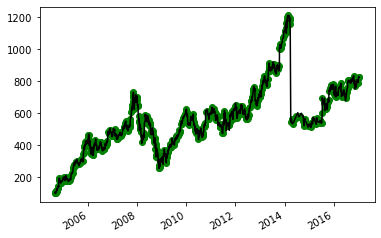

In [19]:
label = out['ret'] * out['bin']
start = '2004-08-19'
end = '2017-01-17'

label = label.loc[(label.index >= start) & (label.index <= end)]
pos_idx = label.loc[label == 1].index
neg_idx = label.loc[label == -1].index
zero_idx = label.loc[label == 0].index
close.loc[label.index].plot(color='k');
plt.scatter(pos_idx, close.loc[pos_idx], color='b');
plt.scatter(neg_idx, close.loc[neg_idx], color='r');
plt.scatter(zero_idx, close.loc[zero_idx], color='g');